In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scstats
import scipy.optimize as sc_op

data = pd.read_csv("/Users/aryasalian/MyProjects-github/JPM Quantitative Research Course Projects/Task 4/Task 3 and 4_Loan_Data copy.csv")
data = data.sort_values(by='fico_score')
fico_scores = data['fico_score']

First, we will analyze how the FICO Scores are distributed in the data and accordingly decide which rule to use to estimate the right number of bins for discretization of the FICO Scores signal.

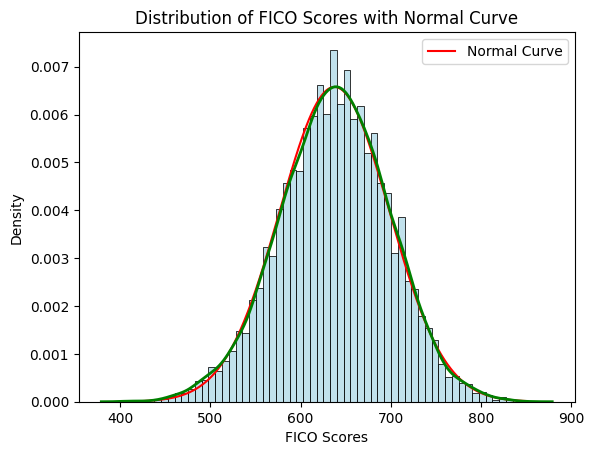

In [2]:
mean_fico = np.mean(fico_scores)
std_dev_fico = np.std(fico_scores)

# Generate a range of values spanning the range of FICO scores
x = np.linspace(min(fico_scores), max(fico_scores), 1000)

# Calculate the corresponding PDF values for each point in the range
pdf_values = scstats.norm.pdf(x, mean_fico, std_dev_fico)
plt.plot(x, pdf_values, color='red', label='Normal Curve')

# Plot Histogram
sns.histplot(fico_scores, kde=False, stat='density', color='lightblue')

# Plot KDE curve
sns.kdeplot(fico_scores, color='green', linewidth=2)

plt.xlabel('FICO Scores')
plt.ylabel('Density')
plt.title('Distribution of FICO Scores with Normal Curve')
plt.legend()
plt.show()

From the Kernel Density Estimation curve(KDE), we can see that the distribution of FICO Scores in the data is more or less Gaussian(Normal). Hence, we can use methods of estimating optimal number of bins which require the assumption that the distribution is of the data is Gaussian. This includes **Sturges' Rule**.

According to Sturge's Rule, **# of bins = 1 + log_2 (n)** where n = size of data

In [3]:
# Finding the optimal number of bins using Sturges' Rule

no_of_bins = 1 + np.log2(len(fico_scores))
print(no_of_bins)

14.287712379549449


Applying Sturges' Rule gives us the optimal number of bins for the data to be **14**. 

The next step is to come up with initial boundaries between each bin which will then be changed in order to optimize a loss function of our choice. Here, I have chosen to optimize the **Log-Likelihood Function** since it takes into account the density of significant observations that should be in each bin to ensure our discretization still maintains the same relationship between our, now discrete, independent variable and model's dependent variable.

In [4]:
initial_boundaries = [439,470,501,532,563,594,625,656,687,718,749,780,811]

def log_likelihood(boundaries):
    bin_sizes = []
    default_counts = []
    default_rates = []

    for i in range(len(boundaries) + 1):
        if i == 0:
            lower_bound = data['fico_score'].min()
        else:
            lower_bound = boundaries[i - 1]

        if i == len(boundaries):
            upper_bound = data['fico_score'].max()
        else:
            upper_bound = boundaries[i]

        bin_data = data[(data['fico_score'] >= lower_bound) & (data['fico_score'] < upper_bound)]
        bin_sizes.append(len(bin_data))
        default_counts.append(bin_data['default'].sum())
        default_rates.append(default_counts[i]/bin_sizes[i])

    # Calculate the negative log-likelihood value because we have to minimize, not maximize
    log_likelihood_value = 0
    for i in range(len(boundaries)):
        log_likelihood_value += default_counts[i] * np.log(default_rates[i]) + (bin_sizes[i] - default_counts[i]) * np.log(1 - default_rates[i])

    return -log_likelihood_value

# Optimization
result = sc_op.minimize(log_likelihood,initial_boundaries,method='Nelder-Mead')

# Extract optimized boundaries
optimized_boundaries = result.x

print(optimized_boundaries)

/var/folders/hb/clzbwtq527b2g9qfk2dhk1yr0000gn/T/ipykernel_42566/671014605.py:22: RuntimeWarning: invalid value encountered in scalar divide
  default_rates.append(default_counts[i]/bin_sizes[i])
/var/folders/hb/clzbwtq527b2g9qfk2dhk1yr0000gn/T/ipykernel_42566/671014605.py:27: RuntimeWarning: divide by zero encountered in log
  log_likelihood_value += default_counts[i] * np.log(default_rates[i]) + (bin_sizes[i] - default_counts[i]) * np.log(1 - default_rates[i])
/var/folders/hb/clzbwtq527b2g9qfk2dhk1yr0000gn/T/ipykernel_42566/671014605.py:27: RuntimeWarning: invalid value encountered in scalar multiply
  log_likelihood_value += default_counts[i] * np.log(default_rates[i]) + (bin_sizes[i] - default_counts[i]) * np.log(1 - default_rates[i])


[440.18019974 466.54147783 502.73104171 546.55214919 569.59564601
 610.38207094 627.90613217 649.80743524 683.17668907 719.38384981
 753.60582457 774.4606979  804.97429343]


After optimizing our bin boundaries by treating a negative Log-Likelihood function as our objective function to be minimized, the solver has arrived at a solution using the Nelder-Mead optimization algorithm and we have our optimal bin boundaries. We minimize the negative log-likelihood function instead of maximizing the positive log-likelihood function because many optimization algorithms are designed to minimize functions, and they may have better convergence properties when minimizing.

Our next and final step will be to define a function that uses a generalized approach to the question and finds the optimal bins for an imputted number of bins. This function will then decide what the quantized value(FICO Rating) of the input signal(FICO Score) should be.

In [5]:
def FICO_Rating (no_of_bins, fico_scores):
    initial_bin_range = (fico_scores.max() - fico_scores.min())/no_of_bins
    initial_boundaries = []
    for i in range(1, no_of_bins):
        initial_boundaries.append(fico_scores.min()+initial_bin_range*i)
    
    def log_likelihood(boundaries):
        bin_sizes = []
        default_counts = []
        default_rates = []

        for i in range(len(boundaries) + 1):
            if i == 0:
                lower_bound = data['fico_score'].min()
            else:
                lower_bound = boundaries[i - 1]

            if i == len(boundaries):
                upper_bound = data['fico_score'].max()
            else:
                upper_bound = boundaries[i]

            bin_data = data[(data['fico_score'] >= lower_bound) & (data['fico_score'] < upper_bound)]
            bin_sizes.append(len(bin_data))
            default_counts.append(bin_data['default'].sum())
            default_rates.append(default_counts[i]/bin_sizes[i])

        # Calculate the negative log-likelihood value because we have to minimize, not maximize
        log_likelihood_value = 0
        for i in range(len(boundaries)):
            log_likelihood_value += default_counts[i] * np.log(default_rates[i]) + (bin_sizes[i] - default_counts[i]) * np.log(1 - default_rates[i])

        return -log_likelihood_value

    # Optimization
    result = sc_op.minimize(log_likelihood,initial_boundaries,method='Nelder-Mead')

    # Extract optimized boundaries
    optimized_boundaries = result.x

    fico_rating = []
    for fico_score in fico_scores:
        if fico_score < optimized_boundaries.min():
            fico_rating.append(no_of_bins)
        for i in range(1, no_of_bins-1):
            if optimized_boundaries[i-1] <= fico_score and fico_score < optimized_boundaries[i]:
                fico_rating.append(no_of_bins-i)
        if optimized_boundaries.max() <= fico_score:
            fico_rating.append(1)

    return fico_rating

fico_ratings = pd.DataFrame(FICO_Rating(14,fico_scores))
print(fico_ratings)


/var/folders/hb/clzbwtq527b2g9qfk2dhk1yr0000gn/T/ipykernel_42566/4060266932.py:26: RuntimeWarning: invalid value encountered in scalar divide
  default_rates.append(default_counts[i]/bin_sizes[i])
/var/folders/hb/clzbwtq527b2g9qfk2dhk1yr0000gn/T/ipykernel_42566/4060266932.py:31: RuntimeWarning: divide by zero encountered in log
  log_likelihood_value += default_counts[i] * np.log(default_rates[i]) + (bin_sizes[i] - default_counts[i]) * np.log(1 - default_rates[i])
/var/folders/hb/clzbwtq527b2g9qfk2dhk1yr0000gn/T/ipykernel_42566/4060266932.py:31: RuntimeWarning: invalid value encountered in scalar multiply
  log_likelihood_value += default_counts[i] * np.log(default_rates[i]) + (bin_sizes[i] - default_counts[i]) * np.log(1 - default_rates[i])


       0
0     14
1     14
2     14
3     14
4     14
...   ..
9995   1
9996   1
9997   1
9998   1
9999   1

[10000 rows x 1 columns]
